In [23]:
# 1. Import thư viện cần thiết
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# **8:1:1**

In [24]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ETH.csv')
df1=df.reset_index()['Close']

In [25]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [26]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [27]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [28]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [29]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [30]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 12s 292ms/step - loss: 0.0427 - val_loss: 3.7467e-04
Epoch 2/100
23/23 [==============================] - 4s 164ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 3/100
23/23 [==============================] - 4s 167ms/step - loss: 0.0031 - val_loss: 3.8234e-04
Epoch 4/100
23/23 [==============================] - 5s 227ms/step - loss: 0.0027 - val_loss: 5.9203e-04
Epoch 5/100
23/23 [==============================] - 4s 164ms/step - loss: 0.0025 - val_loss: 6.6659e-04
Epoch 6/100
23/23 [==============================] - 4s 162ms/step - loss: 0.0024 - val_loss: 3.4233e-04
Epoch 7/100
23/23 [==============================] - 5s 235ms/step - loss: 0.0022 - val_loss: 4.4840e-04
Epoch 8/100
23/23 [==============================] - 4s 166ms/step - loss: 0.0021 - val_loss: 3.7720e-04
Epoch 9/100
23/23 [==============================] - 4s 168ms/step - loss: 0.0021 - val_loss: 2.9094e-04
Epoch 10/100
23/23 [==============================] - 5s 2

In [32]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 38ms/step


In [33]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [34]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 3262.2749496545357
Testing RMSE: 1659.2343968231648
Validation MAE: 3247.85648010186
Testing MAE: 1656.78093802332
Validation MAPE: 0.9997890600727272
Testing MAPE: 0.9997985562785332


In [35]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=130
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.47270777 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382
 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788
 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788
 0.45870516 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897
 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542 0.48103901
 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753

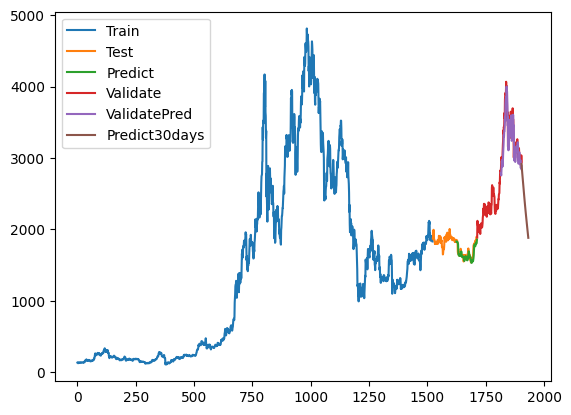

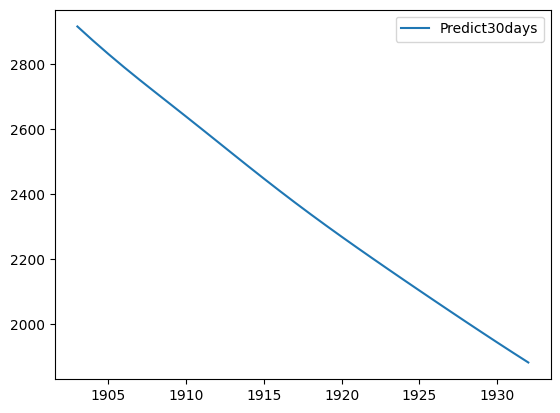

In [36]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [37]:
# 15. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=130
i=0
while(i<60):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.47270777 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382
 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788
 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788
 0.45870516 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897
 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542 0.48103901
 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753

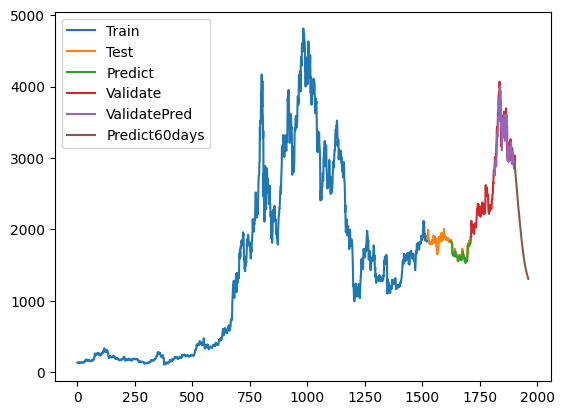

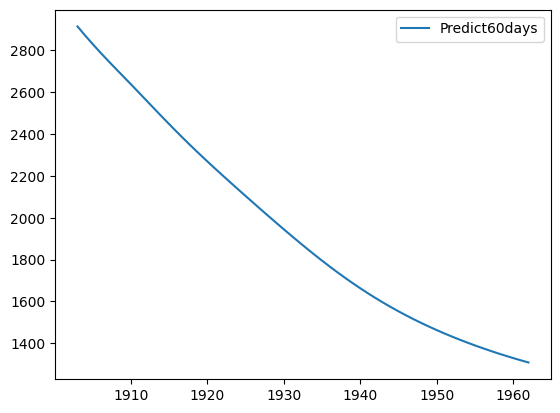

In [38]:
# 16.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict60days'])
plt.show()


# Dự đoán 60 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [39]:
# 17. Dự báo 90 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753 0.6899055
 0.7110288  0.76245899 0.72201867 0.73022326 0.72203664 0.66626424
 0.61561329 0.64795235 0.63618127 0.63263341 0.61132255 0.62861498
 0.62717947 0.64809812 0.6458991  0.65746217 0.66134595 0.64430739
 0.64786039 0.64225689 0.66820689 0.67046287 0.66039249 0.61718439
 0.60814422 0.61205443 0.63659425 0.63957936 0.6437637 

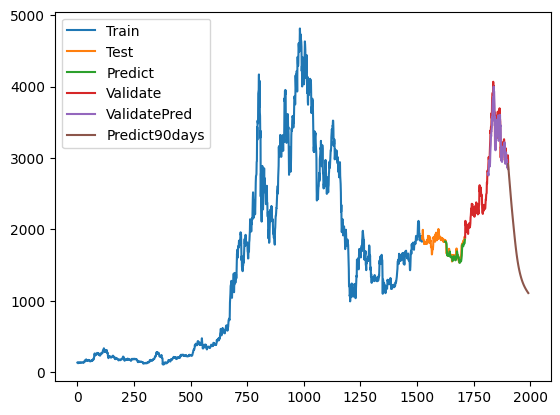

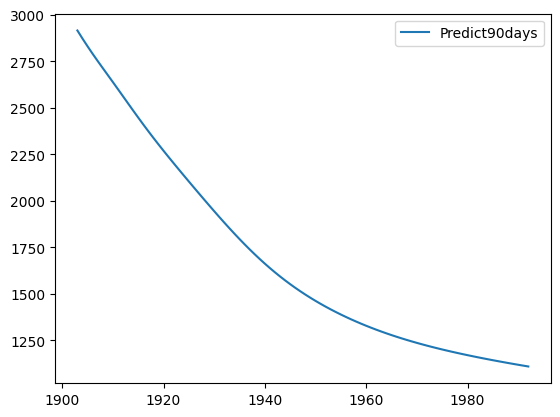

In [40]:
# 18.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict90days'])
plt.show()


# Dự đoán 90 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()

# **7:2:1**

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ETH.csv')
df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 12s 320ms/step - loss: 0.0450 - val_loss: 0.0023
Epoch 2/100
20/20 [==============================] - 4s 181ms/step - loss: 0.0049 - val_loss: 8.2563e-04
Epoch 3/100
20/20 [==============================] - 4s 179ms/step - loss: 0.0036 - val_loss: 3.8453e-04
Epoch 4/100
20/20 [==============================] - 5s 275ms/step - loss: 0.0032 - val_loss: 3.7702e-04
Epoch 5/100
20/20 [==============================] - 5s 230ms/step - loss: 0.0030 - val_loss: 5.8496e-04
Epoch 6/100
20/20 [==============================] - 4s 182ms/step - loss: 0.0029 - val_loss: 3.5597e-04
Epoch 7/100
20/20 [==============================] - 5s 264ms/step - loss: 0.0026 - val_loss: 3.8958e-04
Epoch 8/100
20/20 [==============================] - 4s 181ms/step - loss: 0.0025 - val_loss: 3.7799e-04
Epoch 9/100
20/20 [==============================] - 4s 182ms/step - loss: 0.0025 - val_loss: 8.0754e-04
Epoch 10/100
20/20 [==============================] - 4s 2

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 59ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 3268.2894911907247
Testing RMSE: 1762.3760270257628
Validation MAE: 3253.5426590017787
Testing MAE: 1757.6256582310289
Validation MAPE: 0.9997897345927539
Testing MAPE: 0.9997994563941257


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=131
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.44927542 0.47270777 0.47521643 0.52568486 0.53366439 0.51342419
 0.52451382 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646
 0.50598788 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041
 0.4481788  0.45870516 0.45885113 0.45658009 0.46931128 0.4751455
 0.46196897 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542
 0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.6847

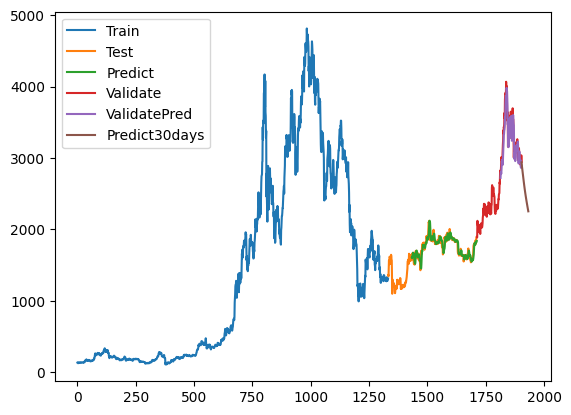

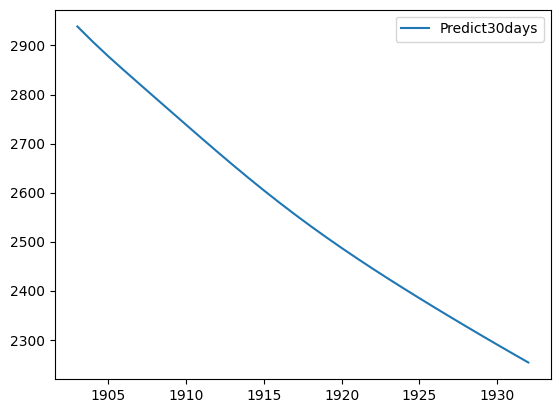

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [ ]:
# 15. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=131
i=0
while(i<60):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.44927542 0.47270777 0.47521643 0.52568486 0.53366439 0.51342419
 0.52451382 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646
 0.50598788 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041
 0.4481788  0.45870516 0.45885113 0.45658009 0.46931128 0.4751455
 0.46196897 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542
 0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.6847

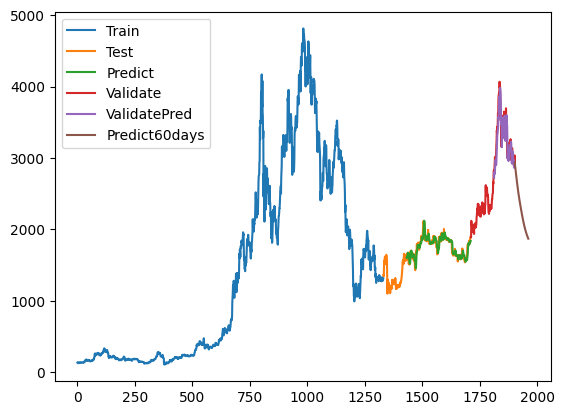

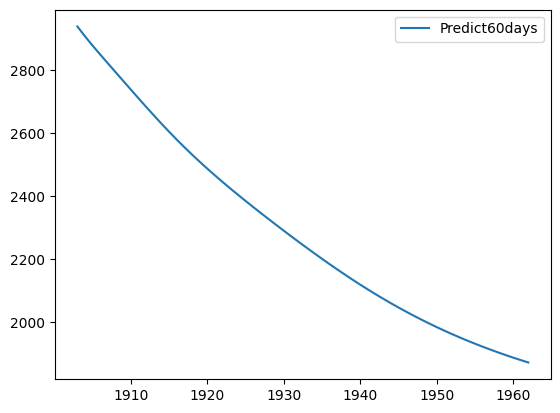

In [ ]:
# 16.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict60days'])
plt.show()


# Dự đoán 60 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [ ]:
# 17. Dự báo 90 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=101
i=0
while(i<90):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753
 0.6899055  0.7110288  0.76245899 0.72201867 0.73022326 0.72203664
 0.66626424 0.61561329 0.64795235 0.63618127 0.63263341 0.61132255
 0.62861498 0.62717947 0.64809812 0.6458991  0.65746217 0.66134595
 0.64430739 0.64786039 0.64225689 0.66820689 0.67046287 0.66039249
 0.61718439 0.60814422 0.61205443 0.63659425 0.639

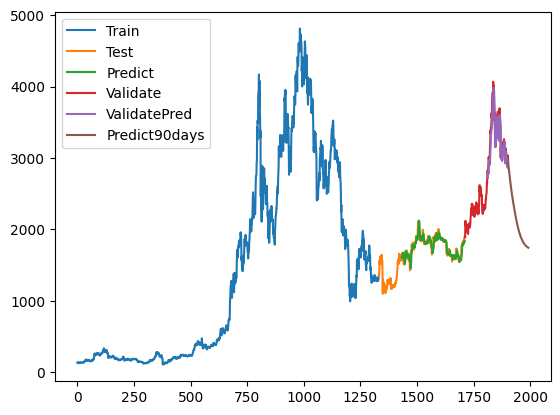

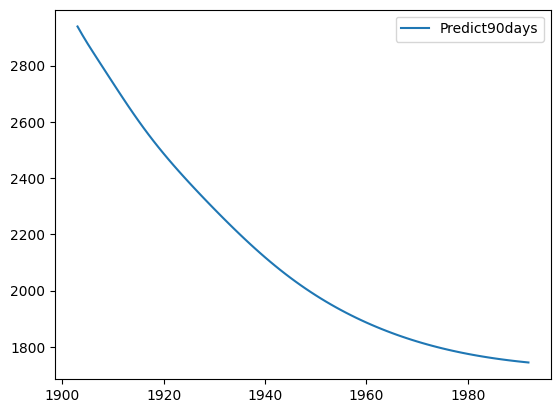

In [ ]:
# 18.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict90days'])
plt.show()


# Dự đoán 90 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()

# **6:2:2**

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ETH.csv')
df1=df.reset_index()['Close']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 12s 311ms/step - loss: 0.0352 - val_loss: 0.0020
Epoch 2/100
17/17 [==============================] - 3s 180ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 3/100
17/17 [==============================] - 3s 178ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 4/100
17/17 [==============================] - 4s 263ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 5/100
17/17 [==============================] - 3s 178ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 6/100
17/17 [==============================] - 3s 177ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 7/100
17/17 [==============================] - 3s 179ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/100
17/17 [==============================] - 4s 261ms/step - loss: 0.0026 - val_loss: 9.2187e-04
Epoch 9/100
17/17 [==============================] - 3s 177ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/100
17/17 [==============================] - 3s 178ms/step - loss: 0.0026 - v

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 37ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 2544.3589024857547
Testing RMSE: 1599.2497762565633
Validation MAE: 2450.8612005652376
Testing MAE: 1582.6456523574404
Validation MAPE: 0.999785074505136
Testing MAPE: 0.9998052565460492


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=321
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.38582733 0.38856528 0.3923834  0.3883941  0.38285424 0.36967722
 0.37434937 0.37327248 0.3727344  0.37646655 0.37599429 0.37467081
 0.40325706 0.38897126 0.38729508 0.38563929 0.3830793  0.38009154
 0.37826418 0.37868132 0.37891762 0.37313908 0.37830326 0.36996768
 0.37161394 0.37468063 0.3721702  0.37523044 0.37657555 0.37244386
 0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.3162

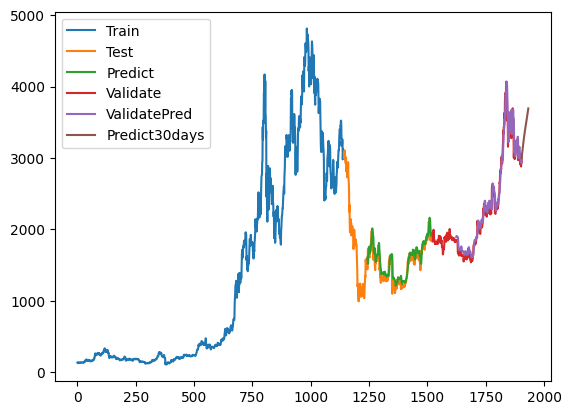

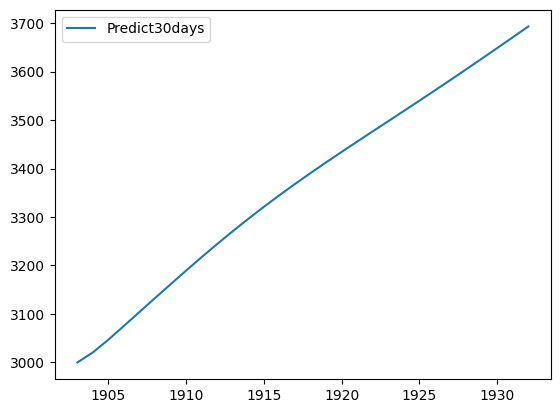

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [18]:
# 15. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=321
i=0
while(i<60):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.38582733 0.38856528 0.3923834  0.3883941  0.38285424 0.36967722
 0.37434937 0.37327248 0.3727344  0.37646655 0.37599429 0.37467081
 0.40325706 0.38897126 0.38729508 0.38563929 0.3830793  0.38009154
 0.37826418 0.37868132 0.37891762 0.37313908 0.37830326 0.36996768
 0.37161394 0.37468063 0.3721702  0.37523044 0.37657555 0.37244386
 0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.3162

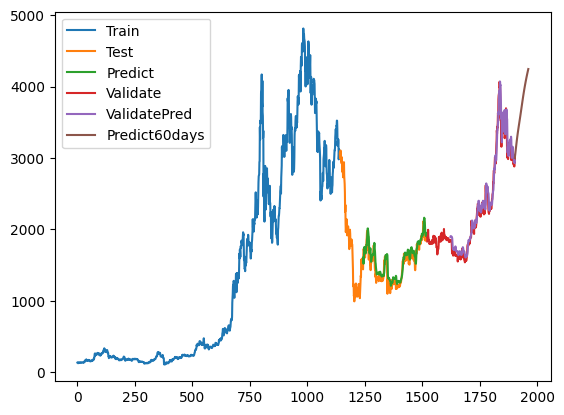

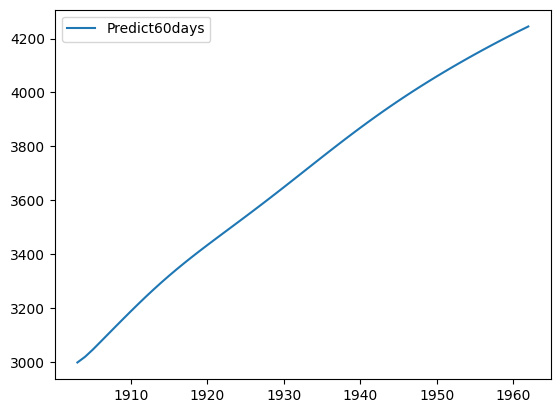

In [19]:
# 16.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict60days'])
plt.show()


# Dự đoán 60 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [21]:
# 17. Dự báo 90 ngày tiếp theo
x_input=val_data[90:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=291
i=0
while(i<90):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.31625889 0.3280406
 0.33124409 0.33192856 0.34525384 0.33032602 0.32884949 0.32696763
 0.31923353 0.32654083 0.32413301 0.32392826 0.3124974  0.3099251
 0.30961493 0.30394814 0.30660199 0.30727569 0.30787401 0.31690615
 0.30944154 0.30908215 0.30987065 0.31778515 0.32302553 0.33028399
 0.35196923 0.35602216 0.35665177 0.36019145 0.355087

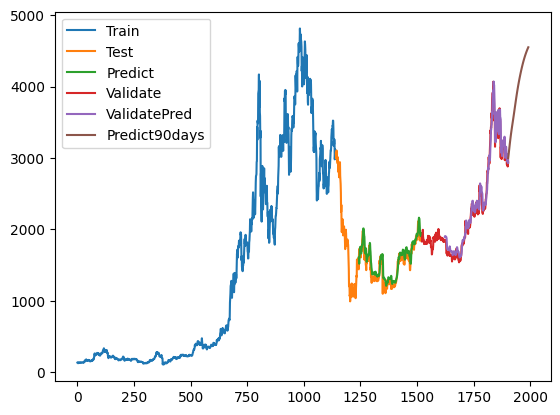

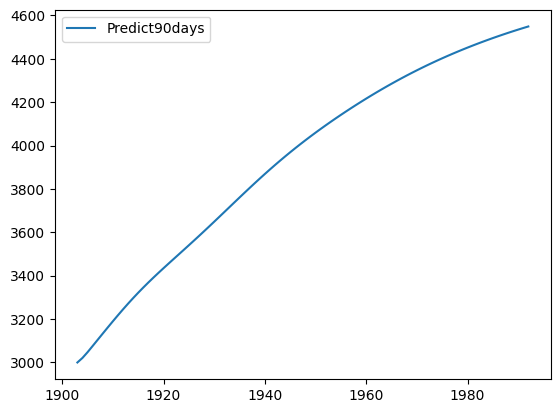

In [22]:
# 18.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict90days'])
plt.show()


# Dự đoán 90 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()